In [12]:
import Missings
using CSV
using Knet
using Plots
using Images, Colors
using Statistics
using StatsBase
include("Adversarial.jl")

Main.adv

In [2]:
include(Knet.dir("data","mnist.jl"))
xsize=784
ysize=10
train, test = mnistdata(xsize=(xsize,:))

┌ Info: Loading MNIST...
└ @ Main C:\Users\PA27879\.julia\packages\Knet\3lzCR\data\mnist.jl:33


(Data(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], UInt8[0x05 0x0a … 0x06 0x08], 100, 60000, false, 1:60000, false, (784, Colon()), (60000,), Array{Float32,N} where N, Array{UInt8,1}), Data(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], UInt8[0x07 0x02 … 0x05 0x06], 100, 10000, false, 1:10000, false, (784, Colon()), (10000,), Array{Float32,N} where N, Array{UInt8,1}))

In [3]:
vals = (784, 64, 10)
model = adv.MLP(vals...)
@show adv.accuracy(model, test)
@time adv.trainresults(model, train; pdrop=(0.2, 0.0))
accuracy(model, test)

adv.accuracy(model, test) = 0.1069
 32.090261 seconds (21.53 M allocations: 26.527 GiB, 9.76% gc time)


0.9781

In [4]:
examples = []
for (x,y) in test
    push!(examples, (x,y))
end

In [5]:
dist = adv.DSSIM
g(x0, model, target) = adv.adv_iterative_gradient_sign(x0, model, target; ϵ=10, α=.01, dist=dist)
example = examples[1]
x0 = example[1][:, 1]
y0 = example[2][1]
println("The sample is a $y0")
target = 10

x1 = g(x0, model, target)

pred = adv.predict_class(model, x1)
dist = dist(x1, x0)
println("The model classifies it as a $pred with a distance of $dist from the original")

The sample is a 7
The model classifies it as a 10 with a distance of 4.526756266304277e-5 from the original


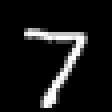

In [6]:
L = Int(√(length(x1)))
img1 = reshape(x0, (L,L))'
Gray.(img1)

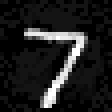

In [7]:
img2 = reshape(x1, (L, L))'
Gray.(img2)

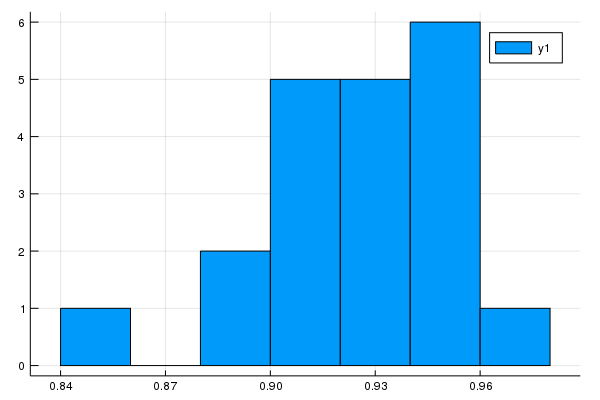

In [8]:
f = adv.adv_iterative_gradient_sign
success_rates = []
for i in 1:20
    append!(success_rates, adv.targetted_test(model, examples; alg=f))
end
histogram(success_rates, fmt=:png)

In [13]:
function remove_missing!(df)
    for col in names(df)
        df[col] = Missings.coalesce.(df[col], 0)
    end
end

function process_binary_data(data, train_rat)
    """
    Takes in data in the form of a DataFrame with a :class
    column containing either 1 or 2 (binary classification)
    Returns a training set, a testing set, and all entries
    in class 2 (for use in permuting them adversarially)
    """
    suspicious = data[data[:class] .== 2, :]
    benign = data[data[:class] .== 1, :]

    train_benign_count = Int(round(size(benign)[1]*train_rat))
    train_susp_count = Int(round(size(suspicious)[1]*train_rat))

    s_train_inds = sample(1:size(suspicious)[1], train_susp_count, replace=false)
    b_train_inds = sample(1:size(benign)[1], train_benign_count, replace=false)
    s_test_inds = setdiff(1:size(suspicious)[1], s_train_inds)
    b_test_inds = setdiff(1:size(benign)[1], b_train_inds)

    s_train = suspicious[s_train_inds, :]
    s_test = suspicious[s_test_inds, :]
    b_train = benign[b_train_inds, :]
    b_test = benign[b_test_inds, :]

    trn = [s_train; b_train]
    remove_missing!(trn)
    tst = [s_test; b_test]
    remove_missing!(tst)

    shuffle = sample(1:size(trn)[1], size(trn)[1], replace=false)
    dtrn = Matrix(trn[shuffle, :])'
    trnx, trny = dtrn[1:end - 1, :], dtrn[end, :]
    # trny = hcat(trny, -trny .+ 1)'
    dtrn = minibatch(trnx, trny, 100)
    shuffle = sample(1:size(tst)[1], size(tst)[1], replace=false)
    dtst = Matrix(tst[shuffle, :])'
    tstx, tsty = dtst[1:end - 1, :], dtst[end, :]
    # tsty = hcat(tsty, -tsty .+ 1)'
    dtst = minibatch(tstx, tsty, 100)

    remove_missing!(suspicious)
    susp = Matrix(suspicious)'[1:end-1, :]
    return dtrn, dtst, susp
end

process_binary_data (generic function with 1 method)

In [14]:
data = CSV.read("malgenome-215-dataset-1260malware-2539-benign.csv")
bin = Dict("B" => 1, "S" => 2)
data[:class] = map(elt->bin[elt], data[:class])

train, test, susp = process_binary_data(data, 0.7)

(Data([1 0 … 1 1; 1 0 … 1 1; … ; 0 0 … 0 0; 0 0 … 0 0], [1 2 … 1 1], 100, 2659, false, 1:2659, false, (215, 2659), (2659,), Array{Int64,2}, Array{Int64,1}), Data([0 1 … 1 0; 0 1 … 1 0; … ; 0 0 … 0 0; 0 0 … 0 0], [2 1 … 1 1], 100, 1140, false, 1:1140, false, (215, 1140), (1140,), Array{Int64,2}, Array{Int64,1}), [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0])

In [ ]:
mw_model = adv.MLP(215, 64, 2)
println(adv.accuracy(mw_model, test))
mlp = adv.trainresults(mw_model, train)
println(adv.accuracy(mw_model, test))

In [ ]:
f = adv.near_search
@time adv.targetted_test(new_model, examples; alg=f)